<a href="https://colab.research.google.com/github/blufzzz/Dynamic-Textures-Autoregression/blob/master/dynamic_textures_AR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook is demo for dynamic texture synthesis via auto-regresion of the frame sequence

In [0]:
# convert videos to frame seq

# root = '../data/dynamic_textures_long'
# for fold in tqdm_notebook(os.listdir(root)):
    
#     texture_fold = os.path.join(root, fold)
#     names = os.listdir(texture_fold)
    
#     if len(names) != 1:
#         print ('check', fold)
#         continue
#     print (texture_fold)
#     video = names[0]
#     video_path = os.path.join(texture_fold, video)
    
#     vidcap = cv2.VideoCapture(video_path)
#     success, image = vidcap.read()
#     count = 0
#     success = True
#     while success:
#       cv2.imwrite(os.path.join(texture_fold, 'frame{}.jpg'.format(count)), image)     # save frame as JPEG file
#       success,image = vidcap.read()
#       count += 1
      
#     os.remove(video_path)  

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
cd ../gdrive/My\ Drive/Colab Notebooks/AR3DCNN

/gdrive/My Drive/Colab Notebooks/AR3DCNN


In [0]:
from skimage import io
import cv2
import os
import sys
import shutil
import re
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from IPython.core.display import clear_output
from IPython.core.debugger import set_trace
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from google.colab import files
from PIL import Image
import matplotlib.animation as anim
from torchvision.transforms import Resize, ToTensor, Compose

SIZE = 64

# Define model

In [0]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch, padding = True):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding= 1 if padding else 0),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding= 1 if padding else 0),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch, padding = True):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch, padding = padding)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x    
      
class concat(nn.Module):
    def __init__(self):
        super(concat, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), x.size(1)*x.size(2), x.size(3), x.size(4))   

In [0]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        '''
        n_channels = dt*3 
        '''
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x.view(x.size(0), x.size(1)*x.size(2), x.size(3), x.size(4)))
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return F.sigmoid(x)
      
      
class Discriminator(nn.Module):      
    def __init__(self, n_channels):
        '''
        n_channels = dl*3 
        '''
        super(Discriminator, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256, padding = False)
        self.down3 = down(256, 512, padding = False)
        self.down4 = down(512, 1024)
        self.dense = nn.Linear(1024, 1)

    def forward(self, x):        
        x1 = self.inc(x.view(x.size(0), x.size(1)*x.size(2), x.size(3), x.size(4)))
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        out = self.dense(x5.squeeze())

        return out.sigmoid()

In [0]:
# dt = 3
# dl = 5
# model = UNet(n_channels = dt*3, n_classes = 3)
# model.forward(torch.randn(10,dt,3,64,64)).shape

In [0]:
SORTING_KEY = lambda x: int( re.findall('\d+' ,x)[0])

def get_seq(fold, seq_len, loss_len, i):
  '''
  Returns tensor-sequense
  '''
  
  transforms = Compose([Resize((SIZE,SIZE)), ToTensor()])
  
  names = sorted(os.listdir(fold), key = SORTING_KEY)

  seq_imgs = []
  loss_imgs = []
  
  assert len(names[i+seq_len:i+seq_len+loss_len]) == loss_len
  for name in names[i+seq_len:i+seq_len+loss_len]:
    
    image_path = os.path.join(fold, name)
    img = Image.open(image_path)
    img_trasformed = transforms(img)
    loss_imgs += [img_trasformed.unsqueeze(1)]
  
  assert len(names[i:i+seq_len]) == seq_len
  for name in names[i:i+seq_len]:
    
    image_path = os.path.join(fold, name)
    img = Image.open(image_path)
    img_trasformed = transforms(img)
    seq_imgs += [img_trasformed.unsqueeze(1)]
    
  seq_imgs = torch.cat(seq_imgs, 1)
  loss_imgs = torch.cat(loss_imgs, 1)

  return seq_imgs, loss_imgs

def deprocess(img_tensor):

    img = img_tensor[0].detach().cpu().numpy().transpose(1,2,0)
    
    img= np.clip(img, 0, 1)
    img = img.astype('float')

    return  img  
  
def extend_sequence(seq, new_img):
    
    dt = seq.shape[2]
    new_seq = torch.cat([seq[:,:,list(range(dt - 1)),...], new_img.unsqueeze(2)],2)
    return new_seq
  
def calculate_n_iter_loss(generator,
                          seq_batch,
                          loss_batch, 
                          loss_coefs = None,
                          loss_type = 'norm',
                          discriminator = None,
                          which_loss = 'gen_loss',
                          eps = 1e-15):
    
    '''
    two types of the loss may be used:
     - 'norm':
     - 'discr':
     - 'both'
    '''
    loss = 0.
    batch_size = loss_batch.shape[0]
    loss_len = loss_batch.shape[2]
    
    if loss_type in ['discr', 'both']:
        predictions = []
    
    if loss_coefs is None:
        loss_coefs = [1./(2**(i)) for i in range(loss_len)]
    
    for i in range(loss_len):
        
        pred = generator(seq_batch)
        if loss_type in ['norm','both']:
            loss += torch.norm(pred - loss_batch[:,:,i,...], 2) / batch_size
            
        if loss_type in ['discr','both']:
            predictions += [pred.unsqueeze(1)]
        
        seq_batch = extend_sequence(seq_batch, pred)
    
    if loss_type in ['discr', 'both']:
        predictions = torch.cat(predictions, 1)
        discr_pred_true = discriminator(loss_batch).clamp(eps, 1.-eps)
        discr_pred_fake = discriminator(predictions).clamp(eps, 1.-eps)
        
        if which_loss == 'gen_loss':
            return -discr_pred_fake.log().mean(0) + 0.1*loss
          
        elif which_loss == 'discr_loss':
            return - (torch.log(1-discr_pred_fake).mean(0) + discr_pred_true.log().mean(0))
    
    return loss

In [0]:
class DynTexDataset(Dataset):
  
    def __init__(self, root_dir, texture_names, seq_len = 4, loss_len = 3, transform=None):

        self.root_dir = root_dir
        self.transform = transform
        self.texture_names = texture_names
        self.seq_len = seq_len
        self.loss_len = loss_len
        self.indx_texture_sequence = []
        
        for name in texture_names:
            texture_fold = os.path.join(root_dir, name)
            n_framesets = len(os.listdir(texture_fold)) - (seq_len + loss_len) + 1
            if n_framesets <= 0:
                continue
            for i in range(n_framesets):
                # i - number of the sequence
                # texture_fold - fold of the seq
                self.indx_texture_sequence.append([texture_fold, i])

    def __getitem__(self, idx):
        
        fold, i = self.indx_texture_sequence[idx]
        return get_seq(fold, self.seq_len, self.loss_len, i)

    def __len__(self):

        return len(self.indx_texture_sequence)
      
def save_model(model,
               losses,
               textures,
               batch_size,
               dt,
               epoch,
               model_type,
               discriminator = None,
               discr_losses = None,
               discr_optimizer = None):
  
#     textures_names = '_'.join(np.unique(re.findall('[a-z,A-Z]+', '_'.join(textures))))
    
    
    PATH = './{0}_training_state_ep{1}_ntext{2}_bs{3}_dt{4}.pt'.format(model_type,
                                                                      epoch,
                                                                      len(textures),
                                                                      batch_size,
                                                                      dt)

    if not os.path.isfile(PATH):
    
        state = {'epoch': epoch,
                  'dt':dt,
                  'batch_size':batch_size,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss_history': losses}
        if discriminator is not None:
            state['discriminator_state_dict'] = discriminator.state_dict()
            state['discr_losses'] = discr_losses
            state['discr_optimizer_state_dict'] = discr_optimizer.state_dict()
        torch.save(state, PATH)


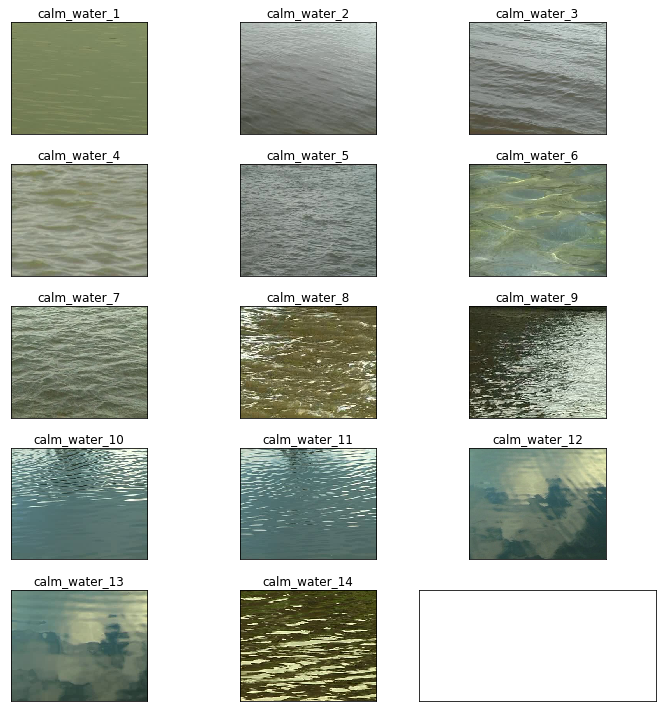

In [9]:
root_fold = './data/dynamic_textures/'

textures = ['calm_water_1',
             'calm_water_2',
             'calm_water_3',
             'calm_water_4',
             'calm_water_5',
             'calm_water_6',
             'calm_water_7',
             'calm_water_8',
             'calm_water_9',
             'calm_water_10',
             'calm_water_11',
             'calm_water_12',
             'calm_water_13',
             'calm_water_14']

N_COLS = 3
fig, axes = plt.subplots(ncols = N_COLS, nrows= len(textures) // N_COLS + 1, sharex = True, sharey = True, figsize = (10,10))
for i, texture in enumerate(textures):
    
    ax = axes.flatten()[i]
    texture_fold = os.path.join(root_fold, texture)
    ax.imshow(plt.imread(os.path.join(texture_fold, os.listdir(texture_fold)[0])))
    ax.set_title(texture)
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()    
plt.show()


# Train model

In [0]:
dt = 4
dl = 5

use_discriminator = True
loss_type = 'both'

losses = []
if use_discriminator:
    discriminator = Discriminator(n_channels = dl*3)
    discriminator = discriminator.cuda()
    discr_losses = []
    optimizer_discr = torch.optim.SGD(discriminator.parameters(),lr=5e-3)
                                  

model = UNet(n_channels = dt*3, n_classes = 3)
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-4,
                             betas = (0.85, 0.999))



In [0]:
dyntex_data = DynTexDataset(root_fold, ['calm_water_6'], dt, dl)
epoch = 1
epochs = 200
print_freq = 10 #epochs // 10
save_freq = 50 #50
batch_size = 30

dataloader = DataLoader(dyntex_data,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=5) 

In [0]:
# checkpoint = torch.load('./UNet_5xloss_discr_training_state_ep5_calm_water_bs30_dt4.pt')

# model.load_state_dict(checkpoint['model_state_dict'])
# discriminator.load_state_dict(checkpoint['discriminator_state_dict'])

# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# # optimizer_discr.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch'] + 1
# losses = checkpoint['loss_history']
# discr_losses = checkpoint['discr_losses']

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


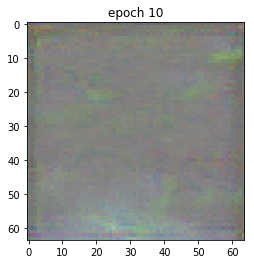

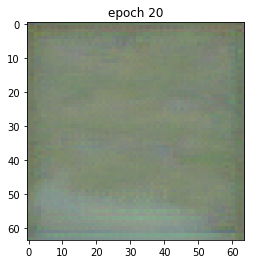

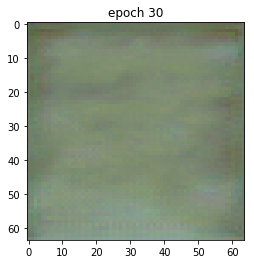

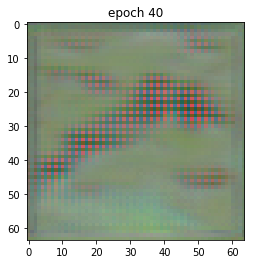

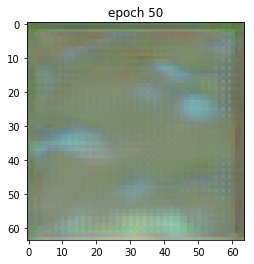

Saving...


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


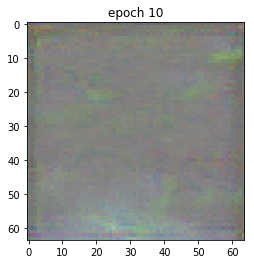

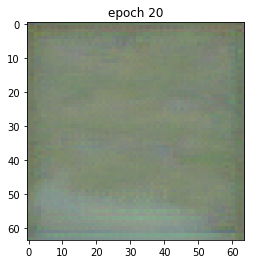

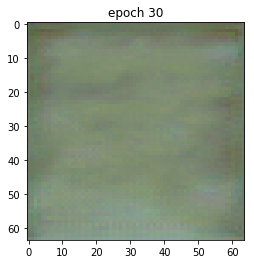

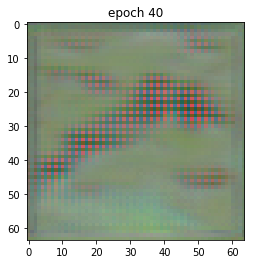

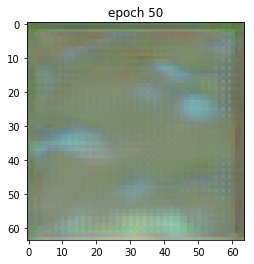

Saving...


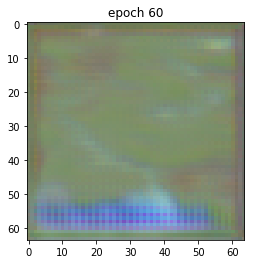

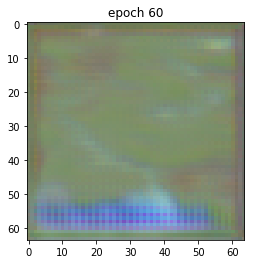

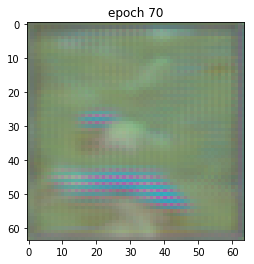

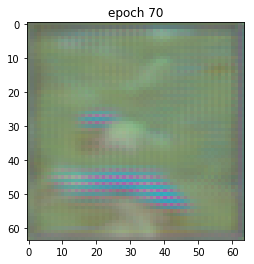

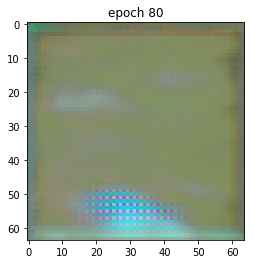

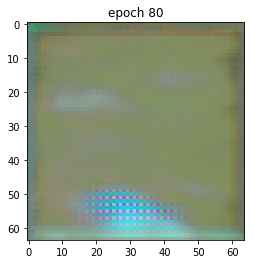

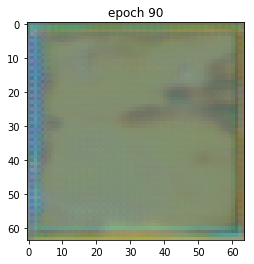

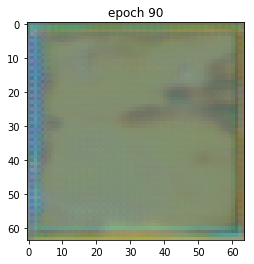

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:

KeyboardInterrupt: ignored

KeyboardInterrupt: ignored

In [15]:
for epoch in tqdm_notebook(range(epoch,epochs + 1)):
  
    model.train()
  
    for seq_batch, loss_batch in tqdm_notebook(dataloader):
        
        seq_batch = seq_batch.cuda()
        loss_batch = loss_batch.cuda()
        
        # generator training
        optimizer.zero_grad()
        loss = calculate_n_iter_loss(model,
                                      seq_batch,
                                      loss_batch, 
                                      loss_coefs = None,
                                      loss_type = loss_type,
                                      discriminator = discriminator,
                                      which_loss = 'gen_loss')
        loss.backward()
        losses += [loss.detach().cpu().numpy()]
        optimizer.step()
        
        # discriminator training
        if use_discriminator:
            optimizer_discr.zero_grad()
            loss = calculate_n_iter_loss(model,
                                          seq_batch,
                                          loss_batch, 
                                          loss_coefs = None,
                                          loss_type = loss_type,
                                          discriminator = discriminator,
                                          which_loss = 'discr_loss')
            loss.backward()
            discr_losses += [loss.detach().cpu().numpy()]
            optimizer_discr.step()
  
    # show
    if epoch%print_freq == 0:
        model.eval()
        plt.figure()
        plt.imshow(deprocess(model(seq_batch)))
        plt.title('epoch {}'.format(epoch))
        plt.grid(False)  
        plt.show()
        
    if epoch%save_freq == 0:
        print ('Saving...')
        save_model(model,
                   losses,
                   textures,
                   batch_size,
                   dt,
                   epoch,
                   model_type = '{0}_{1}xloss_{2}'.format(model.__class__.__name__,dl,loss_type),
                   discriminator = discriminator if use_discriminator else None,
                   discr_losses = discr_losses if use_discriminator else None,
                   discr_optimizer = optimizer_discr if use_discriminator else None)




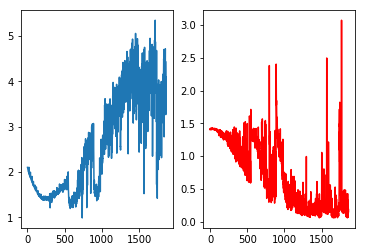

In [17]:
 fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows =1)
ax1.plot(range(len(losses)), losses)
ax2.plot(range(len(discr_losses)), discr_losses, 'r')
plt.show()

## Generation

In [35]:
root_fold = './data/dynamic_textures/'
texture_type = 'calm_water_14'

texture_fold = os.path.join(root_fold, texture_type)

def generate(model, root_fold,  texture_type, dt = 3, seq_len = 30, one_by_one = True):
  
    fold = os.path.join(root_fold, texture_type)
    N = len(os.listdir(fold))
    model.eval()
    
    if not one_by_one:
        assert(seq_len < N)
    
    generate_seq_len = seq_len
    
    starting_seq, _ = get_seq(fold, dt, 1, 0)
    current_seq = starting_seq.unsqueeze(0).cuda()

    generated_imgs = []
    for i in tqdm_notebook(range(generate_seq_len)):
        
        if i >= seq_len:
            break
        
        if not one_by_one:
            if i > N - dt - 1:
                break
              
            current_seq, _ = get_seq(fold, dt, 1, i)
            current_seq = current_seq.unsqueeze(0).cuda()
        
        new_img = model(current_seq)
        generated_imgs += [deprocess(new_img.detach())]  
        
        if one_by_one:
            current_seq = torch.cat([current_seq[:,:,list(range(dt - 1)),...],
                                      new_img.unsqueeze(2)],
                                      2).cuda()
  
    return generated_imgs
        
GEN_SEQ_LEN = 50
generated_imgs = generate(model, root_fold,  texture_type, dt = dt, seq_len = GEN_SEQ_LEN, one_by_one = True)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


OSError: ignored

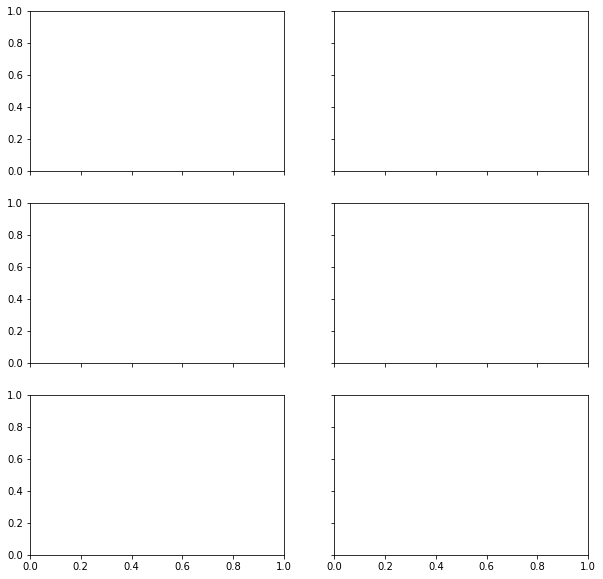

In [0]:
def comparison(generated_seq, texture_fold, n_plot_pairs = 3, dt = 3):
    
    diffs1 = []
    diffs2 = []
    
    fig, axes = plt.subplots(ncols = 2, nrows = n_plot_pairs, sharex=True, sharey=True, figsize = (10,10))
    
    curr_gen = generated_seq[0]
    for i, gen_img in enumerate(generated_seq):
      
        _, img = get_seq(texture_fold, dt, 1, i)
        img = deprocess(img.squeeze().unsqueeze(0))
        
        diff1 = np.linalg.norm(img - gen_img)
        diffs1 += [diff1]
        diff2 = np.linalg.norm(curr_gen - gen_img)
        diffs2 += [diff2]
        
        curr_gen = gen_img
        
        if i < n_plot_pairs: 
            axes[i][0].imshow(img)
            axes[i][0].grid(False)
            axes[i][0].set_title('original, step: {}'.format(i))

            axes[i][1].imshow(gen_img)
            axes[i][1].grid(False)
            axes[i][1].set_title('generated, step: {}'.format(i))

  #     fig.savefig('./comparison.jpg')
  #     files.download('./comparison.jpg')
    plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.0, hspace=0.2)
  #     plt.tight_layout()
    plt.show()
    
    return diffs1, diffs2[1:]
  
dist1, dist2 = comparison(generated_imgs, texture_fold, dt = dt)
rng = range(len(generated_imgs))
plt.figure()
plt.plot(rng, dist1)
plt.xlabel('frame number')
plt.ylabel('diff with original frame')
plt.figure()
plt.plot(dist2)
plt.show()

In [0]:
l6t3_dist1, l6t3_dist2 = dist1, dist2

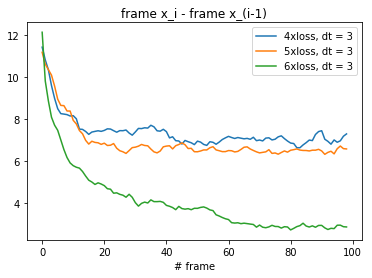

In [0]:
plt.plot(l4t3_dist2, label = '4xloss, dt = 3')
plt.plot(l5t3_dist2, label = '5xloss, dt = 3')
plt.plot(l6t3_dist2, label = '6xloss, dt = 3')
plt.title('frame x_i - frame x_(i-1)')
plt.xlabel('# frame')
plt.legend()

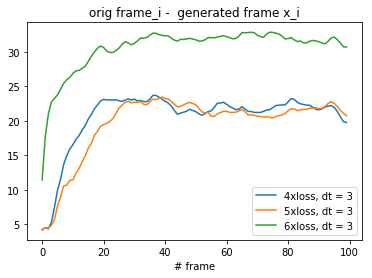

In [0]:
plt.plot(l4t3_dist1, label = '4xloss, dt = 3')
plt.plot(l5t3_dist1, label = '5xloss, dt = 3')
plt.plot(l6t3_dist1, label = '6xloss, dt = 3')
plt.title('orig frame_i -  generated frame x_i')
plt.xlabel('# frame')
plt.legend()

## Saving

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


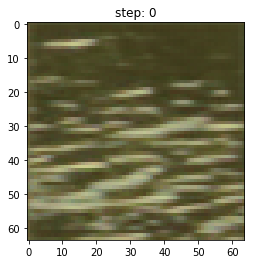

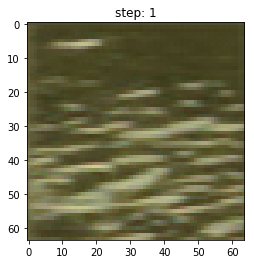

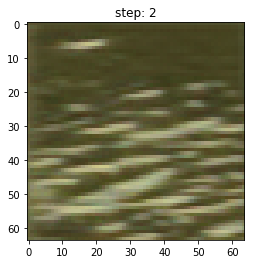

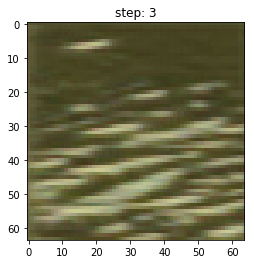

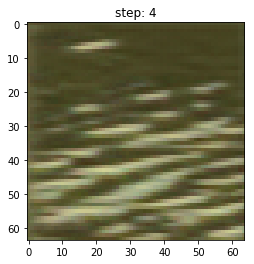

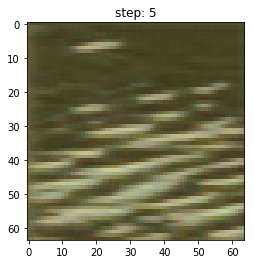

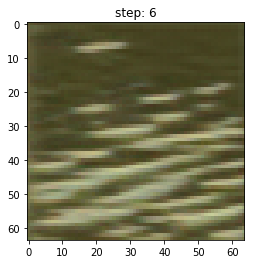

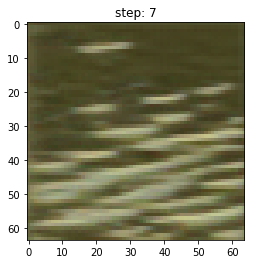

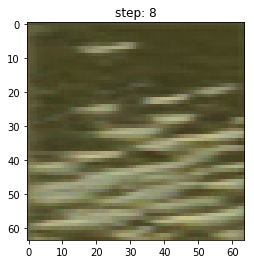

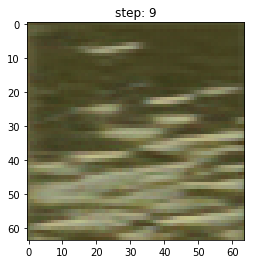

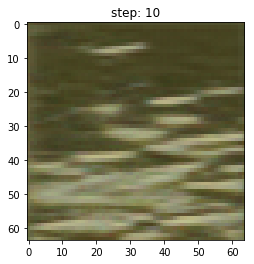

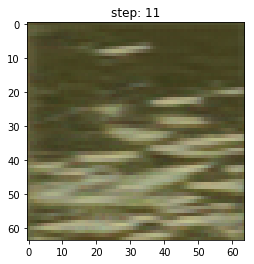

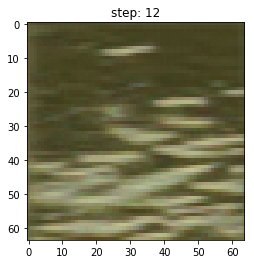

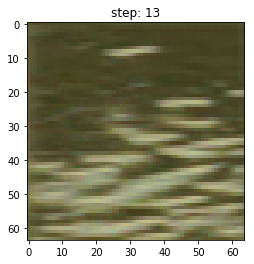

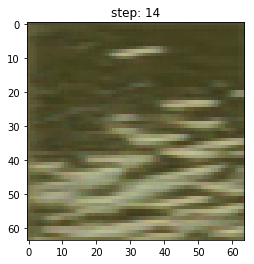

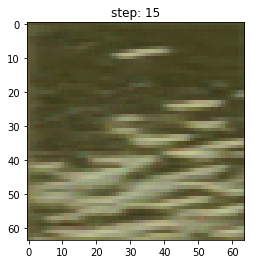

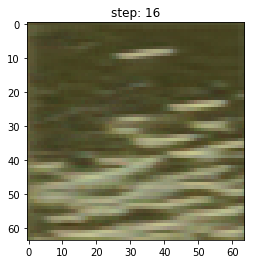

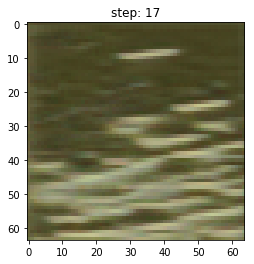

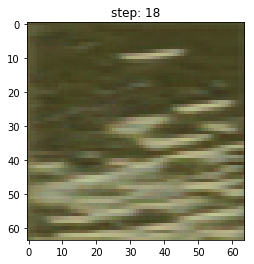

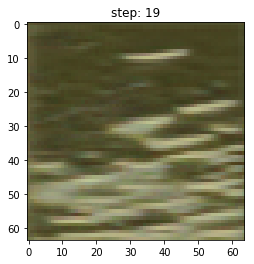

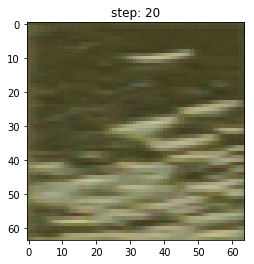

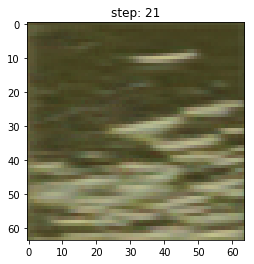

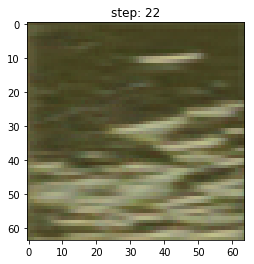

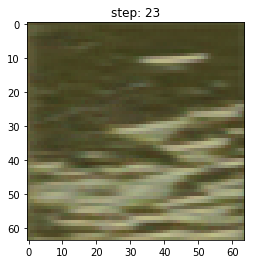

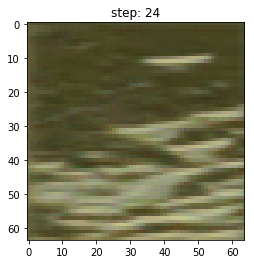

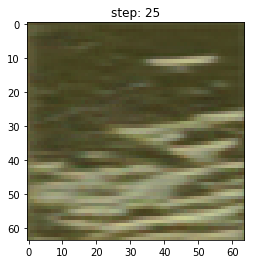

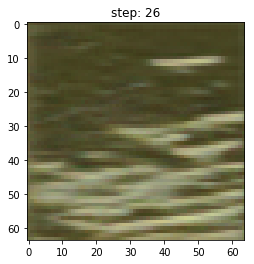

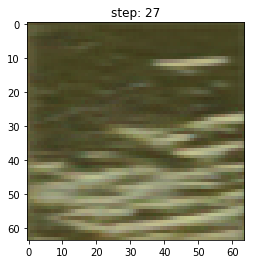

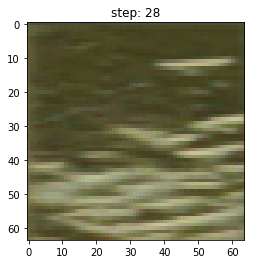

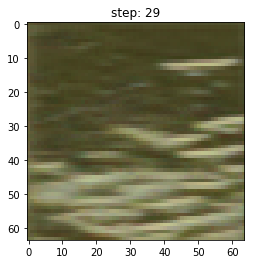

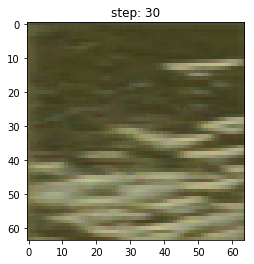

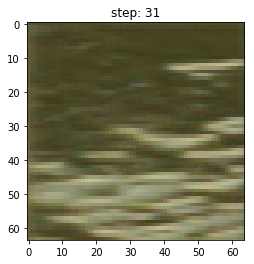

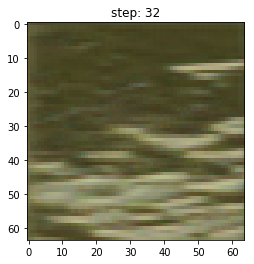

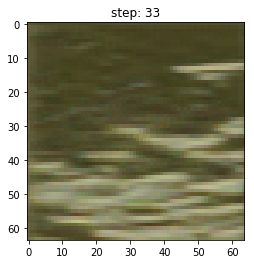

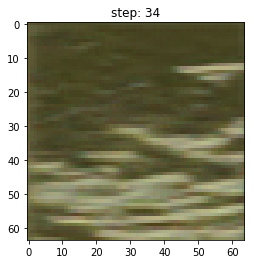

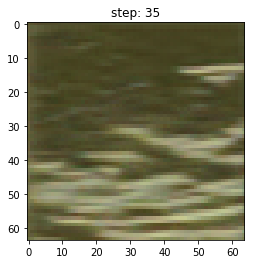

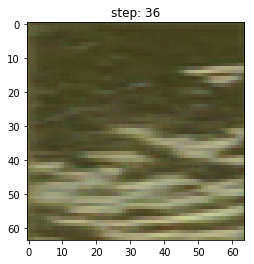

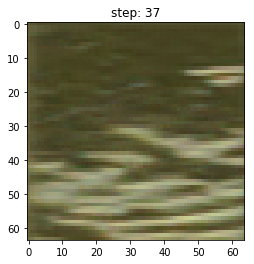

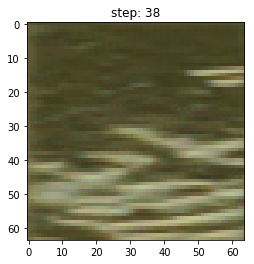

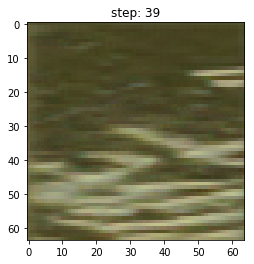

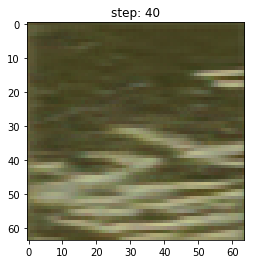

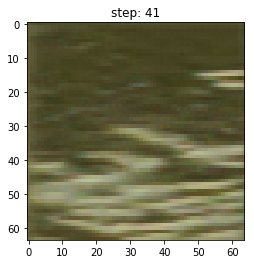

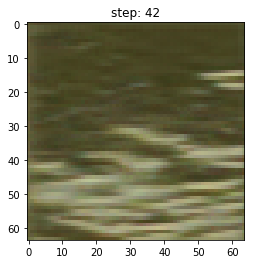

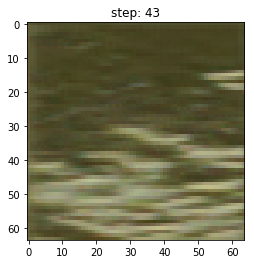

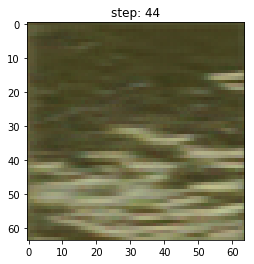

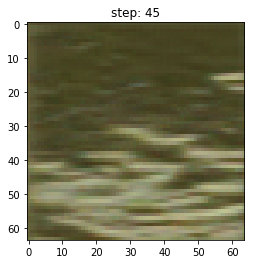

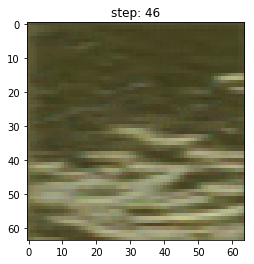

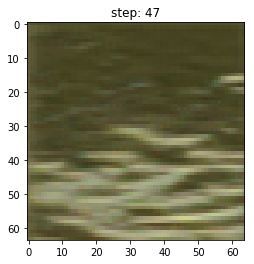

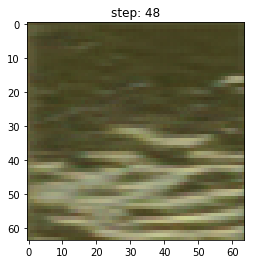

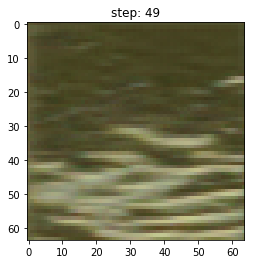

In [36]:
fold_save = './{0}_gen_unet_dt{1}_dl{2}_{3}/'.format(texture_type, dt, dl, GEN_SEQ_LEN)

def save(generated_imgs, fold_save, download = True):

    if save:
        if not os.path.isdir(fold_save):
            os.mkdir(fold_save)
        else:
            shutil.rmtree(fold_save)
            os.mkdir(fold_save)
  
    for i,img in enumerate(generated_imgs):
        
        image_name = os.path.join(fold_save, '{}.jpg'.format(i))
        plt.figure()
        plt.imshow(img)
        plt.grid(False)
        plt.title('step: {}'.format(i))
        plt.savefig(image_name)
        
        if download:
            files.download(image_name)   
            
save(generated_imgs, fold_save)            